In [1]:
# Celda 1: Imports para modelos de árboles y LIME
import lime
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import json
import os
import warnings
from wordcloud import WordCloud
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
# Celda 2: Carga de datasets y parámetros
# Cargar datasets
df_codigos = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_codigos.csv", on_bad_lines='skip', delimiter='|')
df_descr = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_descripciones.csv", on_bad_lines='skip', delimiter='|')
df_comb = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_combinados.csv", on_bad_lines='skip', delimiter='|')

datasets = {
    "codigos": df_codigos,
    "descripciones": df_descr,
    "combinado": df_comb
}

# Cargar parámetros desde JSON
with open(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\tree_params.json", "r") as f:
    all_params = json.load(f)

print("✅ Datasets y parámetros cargados exitosamente")
print(f"📊 Datasets disponibles: {list(datasets.keys())}")

✅ Datasets y parámetros cargados exitosamente
📊 Datasets disponibles: ['codigos', 'descripciones', 'combinado']


In [3]:
# Celda 3: Mapeo de clases de modelos
# Define modelos a probar
model_classes = {
    "RandomForestClassifier": RandomForestClassifier,
    "XGBClassifier": XGBClassifier,
    "GradientBoostingClassifier": GradientBoostingClassifier
}

model_names = {
    "RandomForestClassifier": "Random Forest",
    "XGBClassifier": "XGBoost", 
    "GradientBoostingClassifier": "Gradient Boosting"
}

print("🔧 Modelos configurados:")
for model_key in model_classes.keys():
    print(f"• {model_names[model_key]} ({model_key})")

🔧 Modelos configurados:
• Random Forest (RandomForestClassifier)
• XGBoost (XGBClassifier)
• Gradient Boosting (GradientBoostingClassifier)


In [4]:
# Celda 4: Función para analizar modelo con LIME
def analizar_modelo_lime(df, nombre_dataset, model_class, model_name, params):
    print(f"\n📌 Analizando con LIME {model_name} en dataset: {nombre_dataset}")
    print(f"🔧 Parámetros utilizados: {params}")
    
    # Crear directorio para guardar gráficas
    output_dir = f"lime_plots_trees/{nombre_dataset}_{model_name.replace(' ', '_')}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Preparar datos
    # Combinar todas las columnas excepto la de la etiqueta en un solo texto
    text_columns = [col for col in df.columns if col != 'DIAG PSQ']
    X = df[text_columns].fillna('').astype(str).agg(' '.join, axis=1)
    
    # Preparar la variable objetivo según el dataset
    if nombre_dataset == "codigos":
        y = df['DIAG PSQ'].apply(lambda x: 1 if "F20" in str(x) and "F20.89" not in str(x) else 0)
    elif nombre_dataset == "descripciones":
        y = df['DIAG PSQ'].apply(lambda x: 1 if "Esquizofrenia" in str(x) and "Otros tipos de esquizofrenia" not in str(x) else 0)
    else:  # combinado
        y = df['DIAG PSQ'].apply(lambda x: 1 if "F20.89" in str(x) else 0)
    
    print(f"📈 Distribución de clases: {y.value_counts().to_dict()}")
    
    # Vectorización de texto con configuración más robusta
    vectorizer = TfidfVectorizer(
        max_features=500,  # Reducir features para mejor rendimiento
        stop_words='english',
        dtype=np.float32
    )
    X_vect = vectorizer.fit_transform(X)
    feature_names = vectorizer.get_feature_names_out()
    
    # División de datos
    X_train, X_test, y_train, y_test = train_test_split(
        X_vect, y, test_size=0.2, stratify=y, random_state=42
    )
    
    try:
        # Crear modelo con parámetros específicos
        model = model_class(**params)
        
        # Entrenamiento
        print("🚀 Entrenando modelo...")
        model.fit(X_train, y_train)
        
        # Calcular accuracy para verificar
        accuracy = model.score(X_test, y_test)
        print(f"✅ Accuracy del modelo: {accuracy:.4f}")
        
        # LIME analysis
        print("🔎 Generando explicaciones LIME...")
        
        # Convertir matrices sparse a arrays densos
        X_train_dense = X_train.toarray().astype(np.float32)
        X_test_dense = X_test.toarray().astype(np.float32)
        
        # Crear explainer LIME para datos tabulares
        print("🔧 Creando LIME explainer...")
        explainer = LimeTabularExplainer(
            X_train_dense,
            feature_names=feature_names,
            class_names=['Clase 0', 'Clase 1'],
            mode='classification',
            verbose=True
        )
        
        # Usar una muestra pequeña para LIME
        n_samples = min(5, X_test_dense.shape[0])
        X_lime = X_test_dense[:n_samples]
        
        print(f"📊 Analizando {n_samples} muestras con LIME...")
        
        # Variables para guardar resultados agregados
        all_explanations = []
        feature_importance_dict = {}
        
        # 1. Generar explicaciones individuales para cada muestra
        print("📝 Generando explicaciones individuales...")
        for i in range(n_samples):
            try:
                print(f"   Procesando muestra {i+1}/{n_samples}...")
                
                # Generar explicación LIME
                explanation = explainer.explain_instance(
                    X_lime[i], 
                    model.predict_proba,
                    num_features=20,
                    num_samples=500
                )
                
                all_explanations.append(explanation)
                
                # Guardar explicación como HTML
                explanation.save_to_file(f"{output_dir}/lime_explanation_sample_{i+1}.html")
                print(f"💾 Explicación HTML guardada: {output_dir}/lime_explanation_sample_{i+1}.html")
                
                # Generar gráfico matplotlib para la explicación
                fig = explanation.as_pyplot_figure()
                fig.suptitle(f'LIME Explanation - {model_name} ({nombre_dataset}) - Muestra {i+1}', 
                           fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.savefig(f"{output_dir}/lime_plot_sample_{i+1}.png", dpi=300, bbox_inches='tight')
                plt.show()
                print(f"💾 Gráfico LIME guardado: {output_dir}/lime_plot_sample_{i+1}.png")
                
                # Acumular importancias de características para análisis agregado
                for feature_idx, importance in explanation.as_list():
                    if feature_idx not in feature_importance_dict:
                        feature_importance_dict[feature_idx] = []
                    feature_importance_dict[feature_idx].append(abs(importance))
                
            except Exception as e:
                print(f"⚠️  Error generando explicación LIME {i+1}: {e}")
        
        # 2. Análisis agregado de importancia de características
        print("📊 Generando análisis agregado de importancia...")
        try:
            if feature_importance_dict:
                # Calcular importancia promedio por característica
                avg_importance = {}
                for feature_idx, importances in feature_importance_dict.items():
                    avg_importance[feature_idx] = np.mean(importances)
                
                # Obtener top características
                sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
                top_features = sorted_features[:20]  # Top 20
                
                if top_features:
                    feature_indices, importances = zip(*top_features)
                    feature_labels = [feature_names[idx] for idx in feature_indices]
                    
                    # Gráfico de barras de importancia promedio
                    plt.figure(figsize=(12, 8))
                    plt.barh(range(len(feature_labels)), importances)
                    plt.yticks(range(len(feature_labels)), feature_labels)
                    plt.xlabel('Mean |LIME Importance|')
                    plt.title(f'Feature Importance - {model_name} LIME ({nombre_dataset})', fontsize=14, fontweight='bold')
                    plt.tight_layout()
                    plt.savefig(f"{output_dir}/feature_importance_aggregated.png", dpi=300, bbox_inches='tight')
                    plt.show()
                    print(f"💾 Importancia agregada guardada: {output_dir}/feature_importance_aggregated.png")
                    
                    # 3. Word Cloud de características importantes
                    print("☁️  Generando Word Cloud...")
                    try:
                        # Crear diccionario para word cloud
                        wordcloud_dict = dict(zip(feature_labels, importances))
                        
                        wordcloud = WordCloud(
                            width=800, 
                            height=400, 
                            background_color='white',
                            max_words=50,
                            colormap='viridis'
                        ).generate_from_frequencies(wordcloud_dict)
                        
                        plt.figure(figsize=(12, 6))
                        plt.imshow(wordcloud, interpolation='bilinear')
                        plt.axis('off')
                        plt.title(f'Important Features - {model_name} LIME ({nombre_dataset})', fontsize=14, fontweight='bold')
                        plt.tight_layout()
                        plt.savefig(f"{output_dir}/wordcloud_importance.png", dpi=300, bbox_inches='tight')
                        plt.show()
                        print(f"💾 Word Cloud guardado: {output_dir}/wordcloud_importance.png")
                    except Exception as e:
                        print(f"⚠️  Error generando Word Cloud: {e}")
                    
                    # 4. Heatmap de importancia por muestra
                    print("🔥 Generando Heatmap...")
                    try:
                        # Crear matriz de importancia por muestra
                        top_feature_indices = feature_indices[:10]  # Top 10 para el heatmap
                        top_feature_labels = feature_labels[:10]
                        heatmap_data = []
                        
                        for i, explanation in enumerate(all_explanations):
                            explanation_dict = dict(explanation.as_list())
                            sample_importances = []
                            for feature_idx in top_feature_indices:
                                importance = explanation_dict.get(feature_idx, 0)
                                sample_importances.append(importance)
                            heatmap_data.append(sample_importances)
                        
                        if heatmap_data:
                            plt.figure(figsize=(12, 8))
                            sns.heatmap(
                                np.array(heatmap_data).T, 
                                xticklabels=[f'Muestra {i+1}' for i in range(len(heatmap_data))],
                                yticklabels=top_feature_labels,
                                annot=True, 
                                fmt='.3f', 
                                cmap='RdBu_r',
                                center=0
                            )
                            plt.title(f'Feature Importance Heatmap - {model_name} LIME ({nombre_dataset})', fontsize=14, fontweight='bold')
                            plt.tight_layout()
                            plt.savefig(f"{output_dir}/importance_heatmap.png", dpi=300, bbox_inches='tight')
                            plt.show()
                            print(f"💾 Heatmap guardado: {output_dir}/importance_heatmap.png")
                    except Exception as e:
                        print(f"⚠️  Error generando Heatmap: {e}")
                    
                    # 5. Distribución de importancia por característica
                    print("📈 Generando distribución de importancia...")
                    try:
                        # Seleccionar las top 5 características para el box plot
                        top_5_indices = feature_indices[:5]
                        top_5_labels = feature_labels[:5]
                        
                        importance_distributions = []
                        for feature_idx in top_5_indices:
                            if feature_idx in feature_importance_dict:
                                importance_distributions.append(feature_importance_dict[feature_idx])
                            else:
                                importance_distributions.append([0])
                        
                        plt.figure(figsize=(12, 6))
                        plt.boxplot(importance_distributions, labels=top_5_labels)
                        plt.xlabel('Features')
                        plt.ylabel('LIME Importance')
                        plt.title(f'Distribution of Feature Importance - {model_name} ({nombre_dataset})')
                        plt.xticks(rotation=45, ha='right')
                        plt.tight_layout()
                        plt.savefig(f"{output_dir}/importance_distribution.png", dpi=300, bbox_inches='tight')
                        plt.show()
                        print(f"💾 Distribución guardada: {output_dir}/importance_distribution.png")
                    except Exception as e:
                        print(f"⚠️  Error generando distribución: {e}")
                        
                else:
                    print("⚠️  No se encontraron características importantes")
            else:
                print("⚠️  No se pudo calcular importancia agregada")
                
        except Exception as e:
            print(f"⚠️  Error en análisis agregado: {e}")
            import traceback
            print(f"Traceback: {traceback.format_exc()}")
        
        return model, accuracy
        
    except Exception as e:
        print(f"❌ Error analizando modelo con LIME: {e}")
        print(f"Tipo de error: {type(e).__name__}")
        import traceback
        print(f"Detalles del error:\n{traceback.format_exc()}")
        return None, 0.0

print("✅ Función de análisis LIME para árboles definida")

✅ Función de análisis LIME para árboles definida



🎯 PROCESANDO DATASET CON LIME: CODIGOS

📌 Analizando con LIME Random Forest en dataset: codigos
🔧 Parámetros utilizados: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'class_weight': 'balanced', 'n_estimators': 300, 'max_depth': 30, 'random_state': 42}
📈 Distribución de clases: {0: 1385, 1: 612}
🚀 Entrenando modelo...
✅ Accuracy del modelo: 0.7575
🔎 Generando explicaciones LIME...
🔧 Creando LIME explainer...
📊 Analizando 5 muestras con LIME...
📝 Generando explicaciones individuales...
   Procesando muestra 1/5...
Intercept 0.5550763011074751
Prediction_local [0.45939816]
Right: 0.42317843934554983
💾 Explicación HTML guardada: lime_plots_trees/codigos_Random_Forest/lime_explanation_sample_1.html


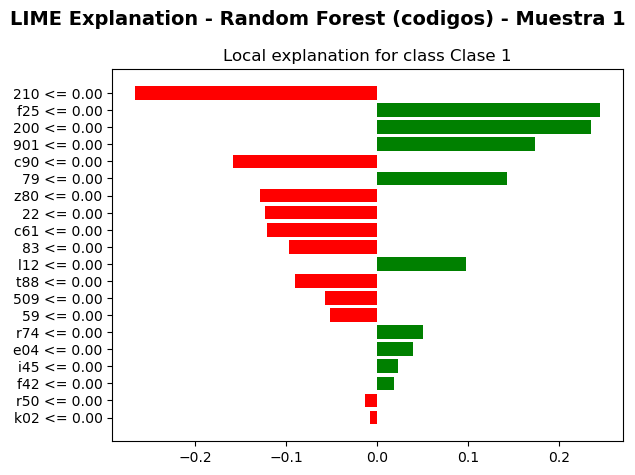

💾 Gráfico LIME guardado: lime_plots_trees/codigos_Random_Forest/lime_plot_sample_1.png
   Procesando muestra 2/5...
Intercept 0.6856490863546851
Prediction_local [0.44355337]
Right: 0.6514221616397234
💾 Explicación HTML guardada: lime_plots_trees/codigos_Random_Forest/lime_explanation_sample_2.html


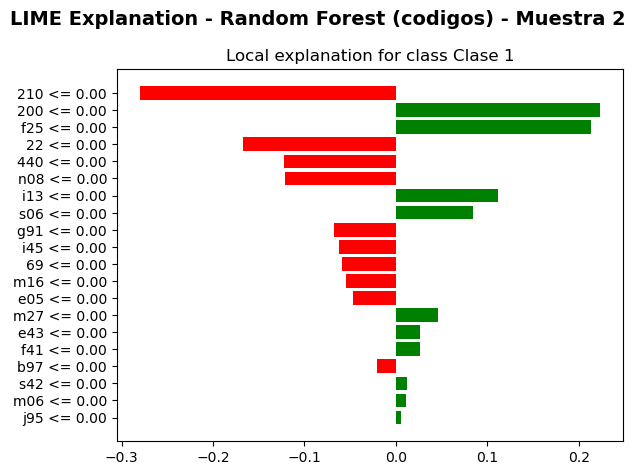

💾 Gráfico LIME guardado: lime_plots_trees/codigos_Random_Forest/lime_plot_sample_2.png
   Procesando muestra 3/5...
Intercept 1.174627979222002
Prediction_local [0.33880087]
Right: 0.46577987006291965
💾 Explicación HTML guardada: lime_plots_trees/codigos_Random_Forest/lime_explanation_sample_3.html


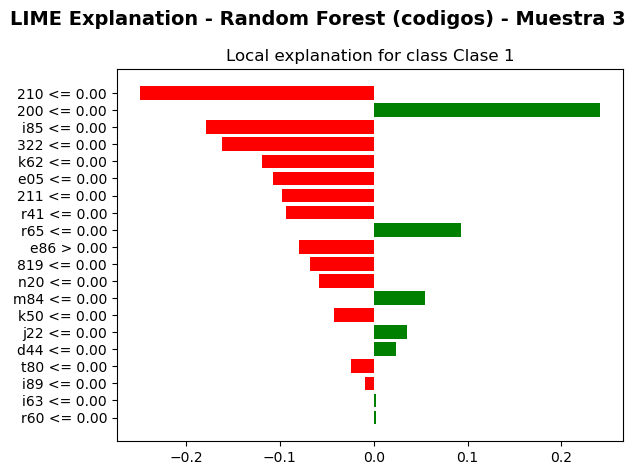

💾 Gráfico LIME guardado: lime_plots_trees/codigos_Random_Forest/lime_plot_sample_3.png
   Procesando muestra 4/5...
Intercept 0.23573922084183513
Prediction_local [0.4986469]
Right: 0.5510300143028767
💾 Explicación HTML guardada: lime_plots_trees/codigos_Random_Forest/lime_explanation_sample_4.html


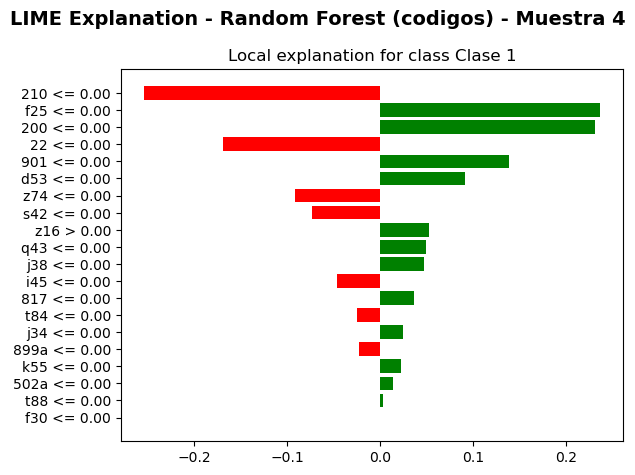

💾 Gráfico LIME guardado: lime_plots_trees/codigos_Random_Forest/lime_plot_sample_4.png
   Procesando muestra 5/5...
Intercept 0.589310699191856
Prediction_local [0.4475055]
Right: 0.6197318240156484
💾 Explicación HTML guardada: lime_plots_trees/codigos_Random_Forest/lime_explanation_sample_5.html


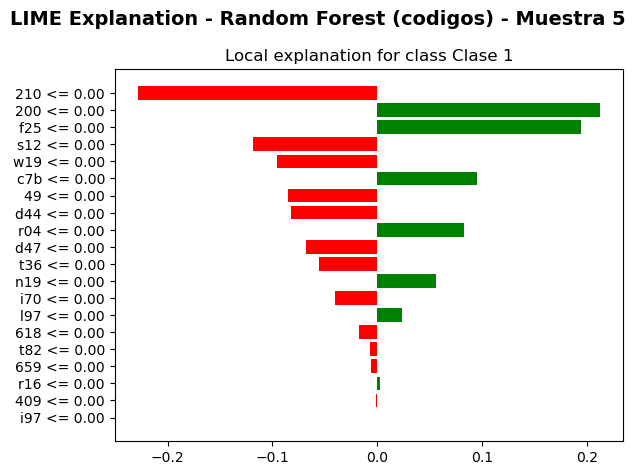

💾 Gráfico LIME guardado: lime_plots_trees/codigos_Random_Forest/lime_plot_sample_5.png
📊 Generando análisis agregado de importancia...
⚠️  Error en análisis agregado: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Traceback: Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_9524\4198431211.py", line 131, in analizar_modelo_lime
    feature_labels = [feature_names[idx] for idx in feature_indices]
                      ~~~~~~~~~~~~~^^^^^
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


📌 Analizando con LIME XGBoost en dataset: codigos
🔧 Parámetros utilizados: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 9, 'subsample': 0.8, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'gamma': 0.5, 'scale_pos_weight': 2, 'random_state': 42}
📈 Distribución de clases: {0: 1385, 1: 612}
🚀 Entrenando mo

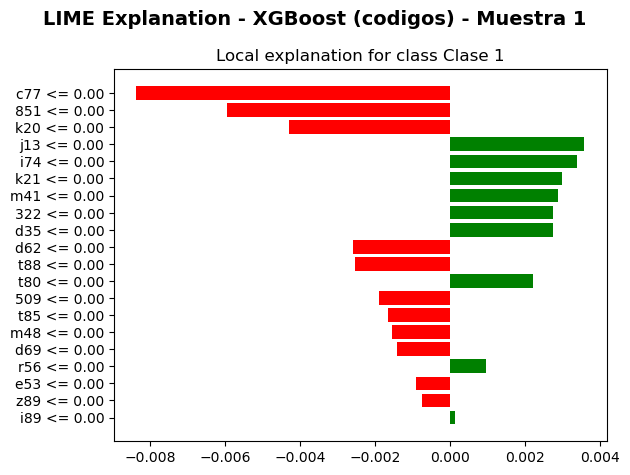

💾 Gráfico LIME guardado: lime_plots_trees/codigos_XGBoost/lime_plot_sample_1.png
   Procesando muestra 2/5...
Intercept 0.02474620976191033
Prediction_local [0.02073801]
Right: 0.019635797
💾 Explicación HTML guardada: lime_plots_trees/codigos_XGBoost/lime_explanation_sample_2.html


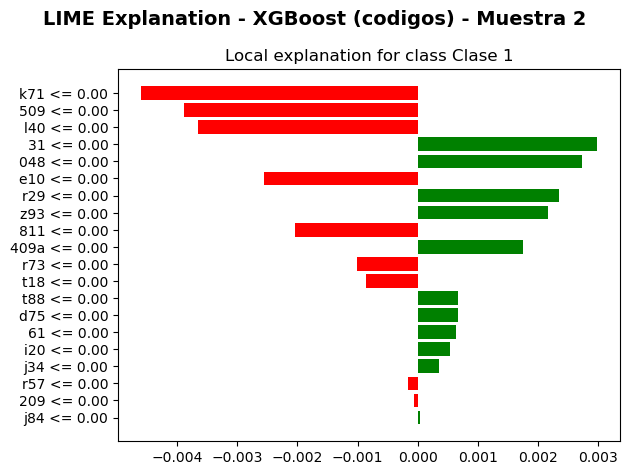

💾 Gráfico LIME guardado: lime_plots_trees/codigos_XGBoost/lime_plot_sample_2.png
   Procesando muestra 3/5...
Intercept 0.032593779898265056
Prediction_local [0.020619]
Right: 0.017332973
💾 Explicación HTML guardada: lime_plots_trees/codigos_XGBoost/lime_explanation_sample_3.html


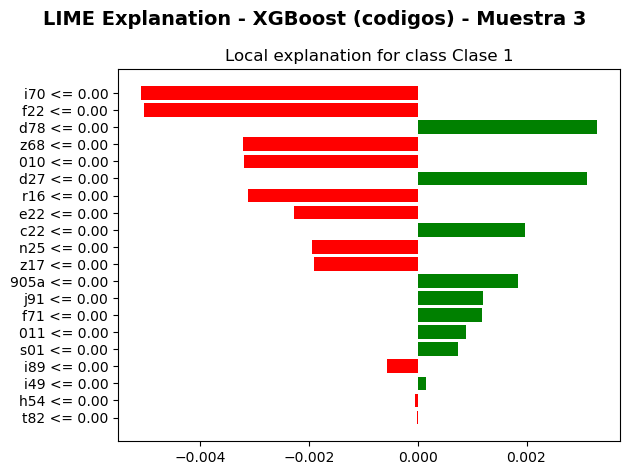

💾 Gráfico LIME guardado: lime_plots_trees/codigos_XGBoost/lime_plot_sample_3.png
   Procesando muestra 4/5...
Intercept 0.020922173652163978
Prediction_local [0.02067295]
Right: 0.02015668
💾 Explicación HTML guardada: lime_plots_trees/codigos_XGBoost/lime_explanation_sample_4.html


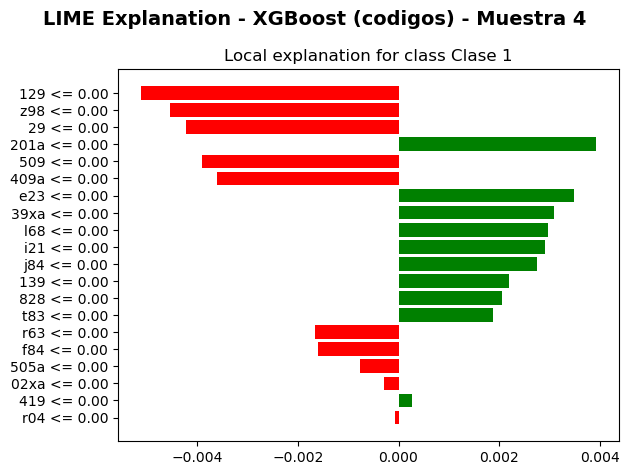

💾 Gráfico LIME guardado: lime_plots_trees/codigos_XGBoost/lime_plot_sample_4.png
   Procesando muestra 5/5...
Intercept 0.019078638355787006
Prediction_local [0.02068609]
Right: 0.02167074
💾 Explicación HTML guardada: lime_plots_trees/codigos_XGBoost/lime_explanation_sample_5.html


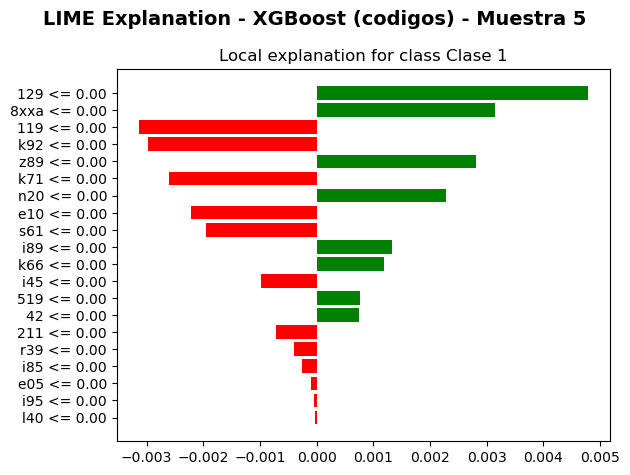

💾 Gráfico LIME guardado: lime_plots_trees/codigos_XGBoost/lime_plot_sample_5.png
📊 Generando análisis agregado de importancia...
⚠️  Error en análisis agregado: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Traceback: Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_9524\4198431211.py", line 131, in analizar_modelo_lime
    feature_labels = [feature_names[idx] for idx in feature_indices]
                      ~~~~~~~~~~~~~^^^^^
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


📌 Analizando con LIME Gradient Boosting en dataset: codigos
🔧 Parámetros utilizados: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 42, 'min_samples_split': 10, 'min_samples_leaf': 2, 'subsample': 1, 'max_features': None}
📈 Distribución de clases: {0: 1385, 1: 612}
🚀 Entrenando modelo...
✅ Accu

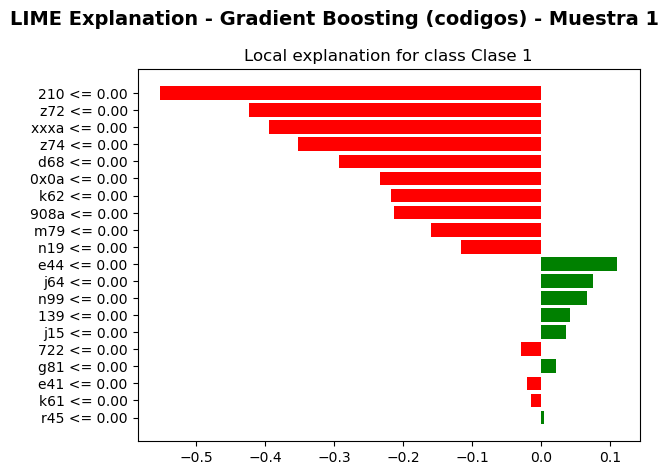

💾 Gráfico LIME guardado: lime_plots_trees/codigos_Gradient_Boosting/lime_plot_sample_1.png
   Procesando muestra 2/5...
Intercept 0.6865441015107607
Prediction_local [0.26646025]
Right: 0.761286375498722
💾 Explicación HTML guardada: lime_plots_trees/codigos_Gradient_Boosting/lime_explanation_sample_2.html


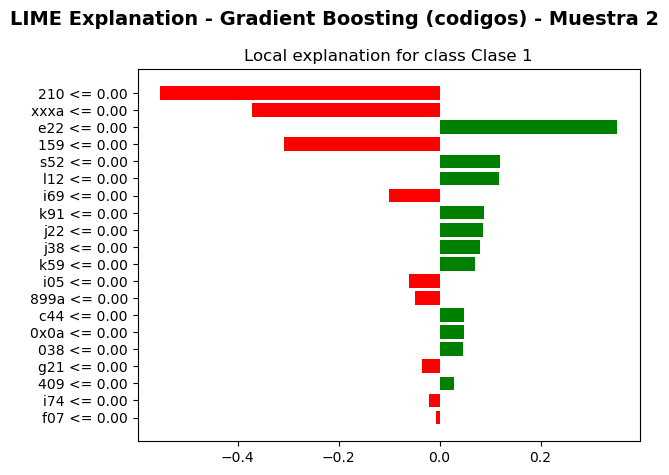

💾 Gráfico LIME guardado: lime_plots_trees/codigos_Gradient_Boosting/lime_plot_sample_2.png
   Procesando muestra 3/5...
Intercept 3.731576091725852
Prediction_local [0.25191348]
Right: 0.13954324620113132
💾 Explicación HTML guardada: lime_plots_trees/codigos_Gradient_Boosting/lime_explanation_sample_3.html


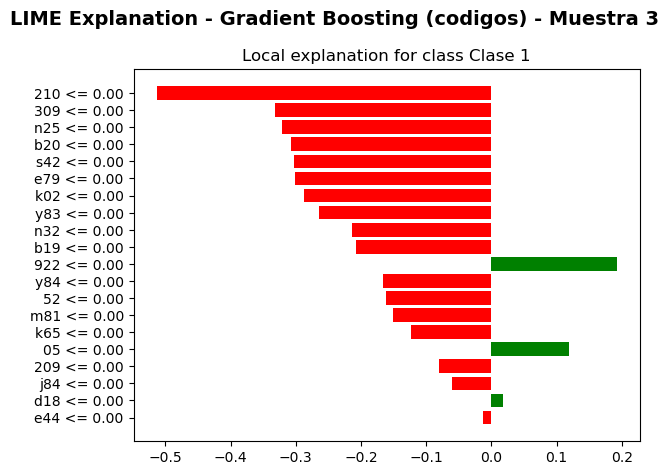

💾 Gráfico LIME guardado: lime_plots_trees/codigos_Gradient_Boosting/lime_plot_sample_3.png
   Procesando muestra 4/5...
Intercept 2.8501682119986858
Prediction_local [0.24977544]
Right: 0.22382833832117965
💾 Explicación HTML guardada: lime_plots_trees/codigos_Gradient_Boosting/lime_explanation_sample_4.html


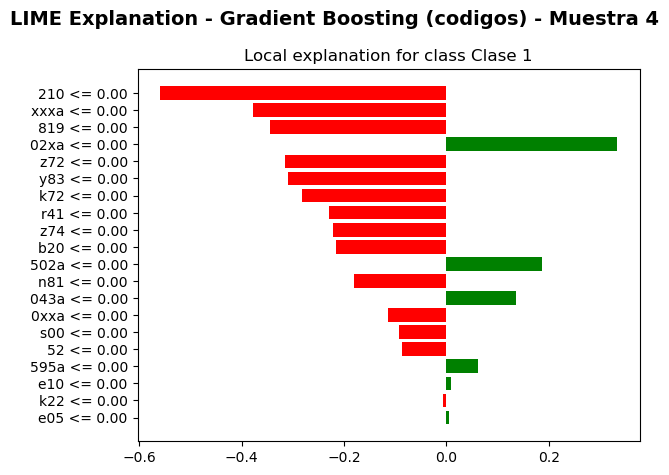

💾 Gráfico LIME guardado: lime_plots_trees/codigos_Gradient_Boosting/lime_plot_sample_4.png
   Procesando muestra 5/5...
Intercept 1.7589997420829628
Prediction_local [0.25840237]
Right: 0.406938059707126
💾 Explicación HTML guardada: lime_plots_trees/codigos_Gradient_Boosting/lime_explanation_sample_5.html


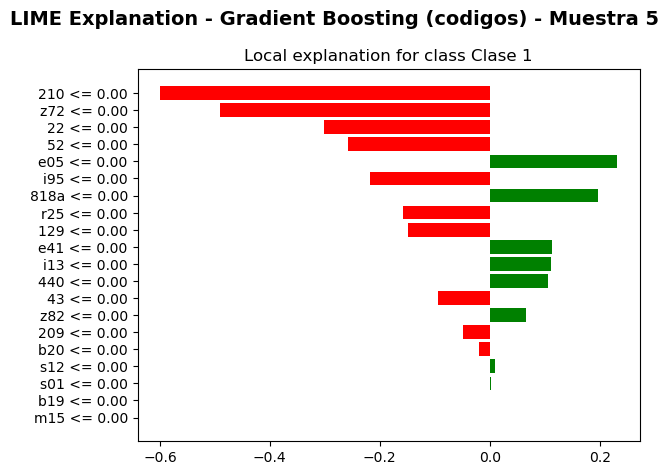

💾 Gráfico LIME guardado: lime_plots_trees/codigos_Gradient_Boosting/lime_plot_sample_5.png
📊 Generando análisis agregado de importancia...
⚠️  Error en análisis agregado: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Traceback: Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_9524\4198431211.py", line 131, in analizar_modelo_lime
    feature_labels = [feature_names[idx] for idx in feature_indices]
                      ~~~~~~~~~~~~~^^^^^
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


🎯 PROCESANDO DATASET CON LIME: DESCRIPCIONES

📌 Analizando con LIME Random Forest en dataset: descripciones
🔧 Parámetros utilizados: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'class_weight': 'balanced', 'n_estimators': 300, 'max_depth': 30, 

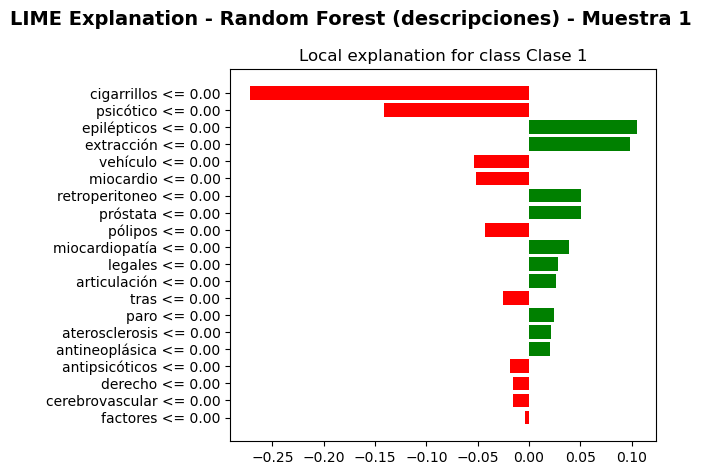

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_Random_Forest/lime_plot_sample_1.png
   Procesando muestra 2/5...
Intercept 0.9771199360430236
Prediction_local [0.55408289]
Right: 0.676396684899163
💾 Explicación HTML guardada: lime_plots_trees/descripciones_Random_Forest/lime_explanation_sample_2.html


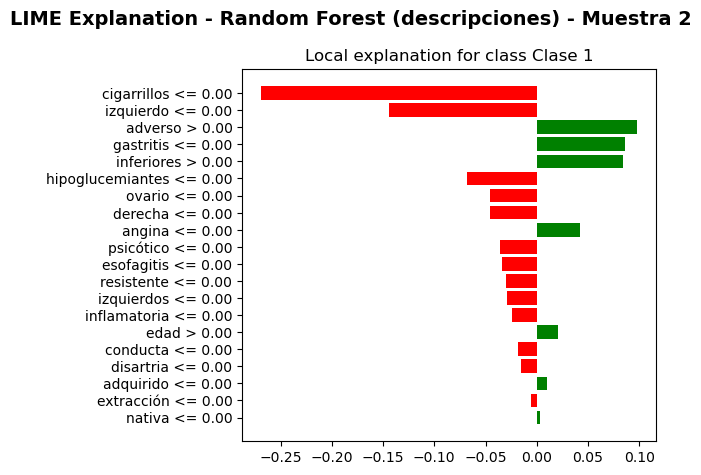

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_Random_Forest/lime_plot_sample_2.png
   Procesando muestra 3/5...
Intercept 0.7398217710168784
Prediction_local [0.3626814]
Right: 0.04990255825055843
💾 Explicación HTML guardada: lime_plots_trees/descripciones_Random_Forest/lime_explanation_sample_3.html


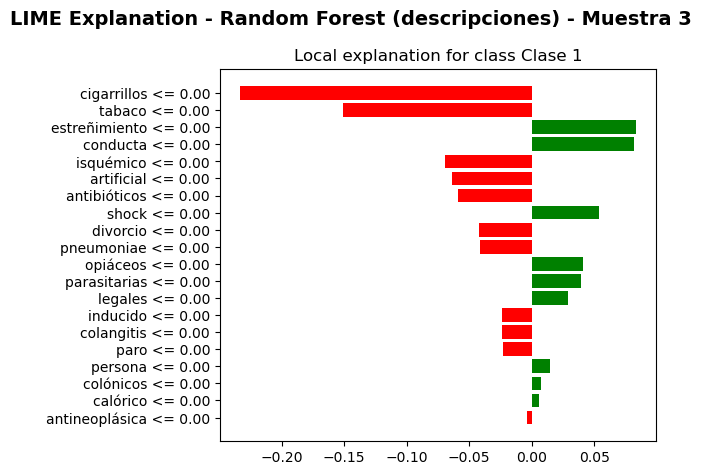

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_Random_Forest/lime_plot_sample_3.png
   Procesando muestra 4/5...
Intercept 0.9489511832035216
Prediction_local [0.38173566]
Right: 0.6722335220616203
💾 Explicación HTML guardada: lime_plots_trees/descripciones_Random_Forest/lime_explanation_sample_4.html


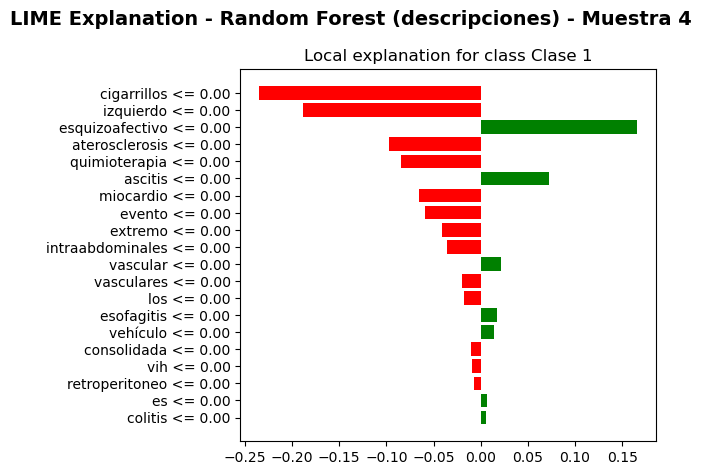

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_Random_Forest/lime_plot_sample_4.png
   Procesando muestra 5/5...
Intercept 0.5966735707684174
Prediction_local [0.38529812]
Right: 0.39701592385160106
💾 Explicación HTML guardada: lime_plots_trees/descripciones_Random_Forest/lime_explanation_sample_5.html


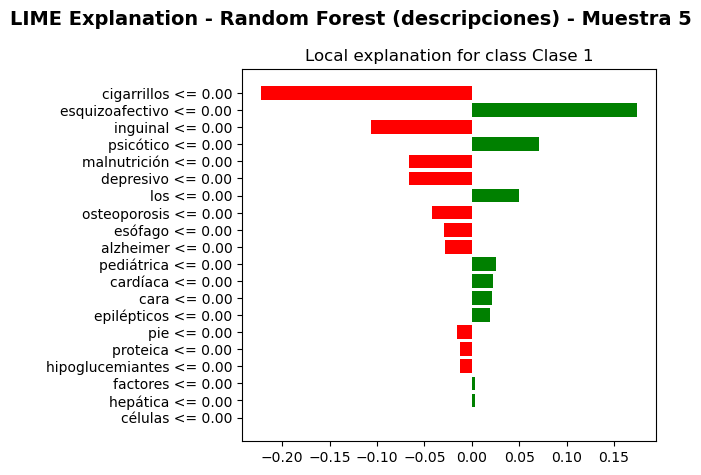

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_Random_Forest/lime_plot_sample_5.png
📊 Generando análisis agregado de importancia...
⚠️  Error en análisis agregado: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Traceback: Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_9524\4198431211.py", line 131, in analizar_modelo_lime
    feature_labels = [feature_names[idx] for idx in feature_indices]
                      ~~~~~~~~~~~~~^^^^^
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


📌 Analizando con LIME XGBoost en dataset: descripciones
🔧 Parámetros utilizados: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'gamma': 0.2, 'scale_pos_weight': 2, 'random_state': 42}
📈 Distribución de clases: {0: 1394, 1: 603}
🚀 En

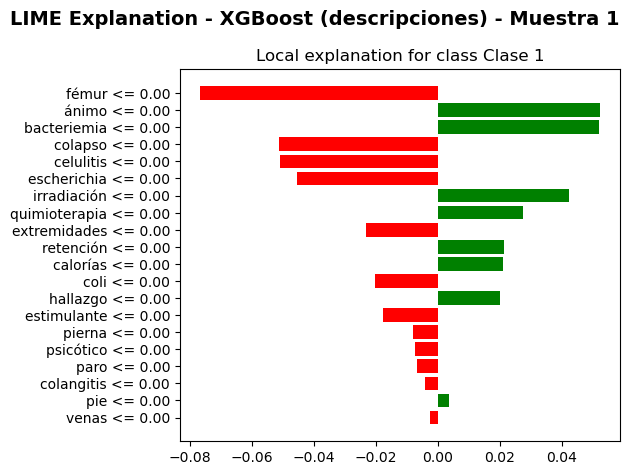

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_XGBoost/lime_plot_sample_1.png
   Procesando muestra 2/5...
Intercept 0.6095614721181132
Prediction_local [0.54337322]
Right: 0.68697953
💾 Explicación HTML guardada: lime_plots_trees/descripciones_XGBoost/lime_explanation_sample_2.html


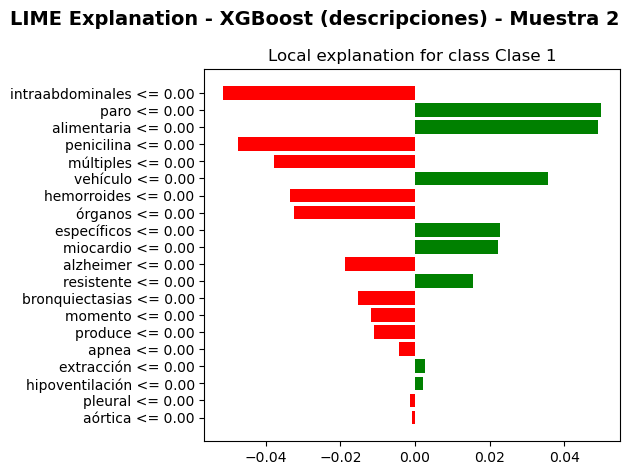

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_XGBoost/lime_plot_sample_2.png
   Procesando muestra 3/5...
Intercept 0.24078433552141548
Prediction_local [0.54434682]
Right: 0.61741376
💾 Explicación HTML guardada: lime_plots_trees/descripciones_XGBoost/lime_explanation_sample_3.html


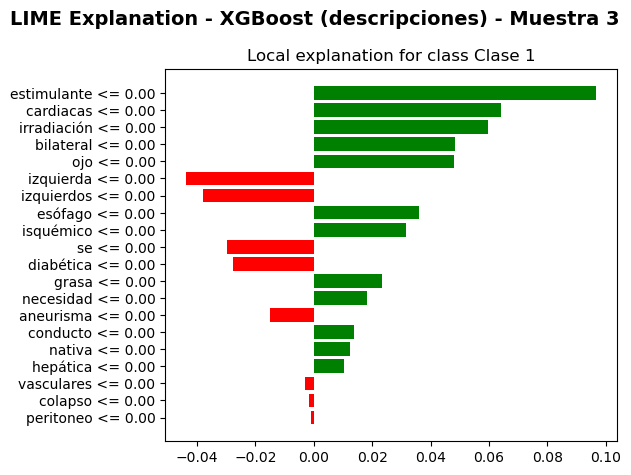

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_XGBoost/lime_plot_sample_3.png
   Procesando muestra 4/5...
Intercept 0.44005382827674194
Prediction_local [0.54495212]
Right: 0.5317769
💾 Explicación HTML guardada: lime_plots_trees/descripciones_XGBoost/lime_explanation_sample_4.html


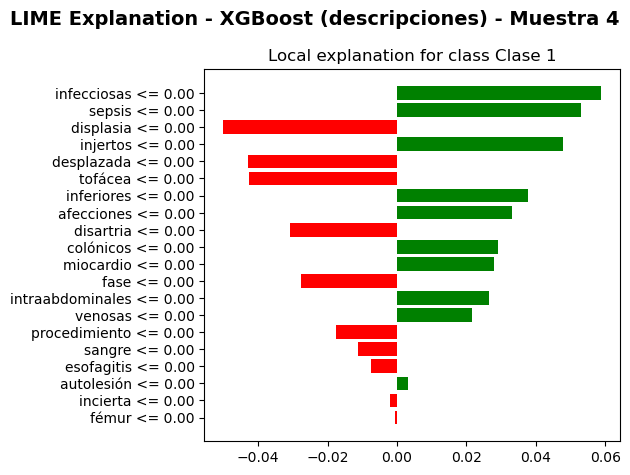

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_XGBoost/lime_plot_sample_4.png
   Procesando muestra 5/5...
Intercept 0.7625474347287684
Prediction_local [0.49398912]
Right: 0.33360913
💾 Explicación HTML guardada: lime_plots_trees/descripciones_XGBoost/lime_explanation_sample_5.html


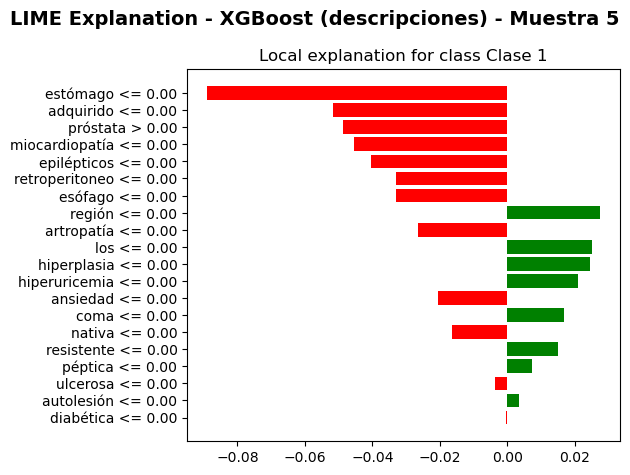

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_XGBoost/lime_plot_sample_5.png
📊 Generando análisis agregado de importancia...
⚠️  Error en análisis agregado: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Traceback: Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_9524\4198431211.py", line 131, in analizar_modelo_lime
    feature_labels = [feature_names[idx] for idx in feature_indices]
                      ~~~~~~~~~~~~~^^^^^
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


📌 Analizando con LIME Gradient Boosting en dataset: descripciones
🔧 Parámetros utilizados: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 5, 'random_state': 42, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.8, 'max_features': None}
📈 Distribución de clases: {0: 1394, 1: 603}
🚀 Entrenando mo

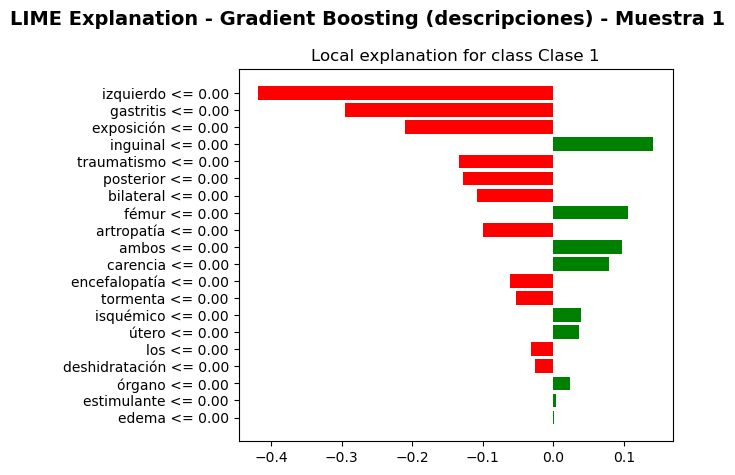

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_Gradient_Boosting/lime_plot_sample_1.png
   Procesando muestra 2/5...
Intercept 1.310882102003172
Prediction_local [0.29193985]
Right: 0.9357543182487968
💾 Explicación HTML guardada: lime_plots_trees/descripciones_Gradient_Boosting/lime_explanation_sample_2.html


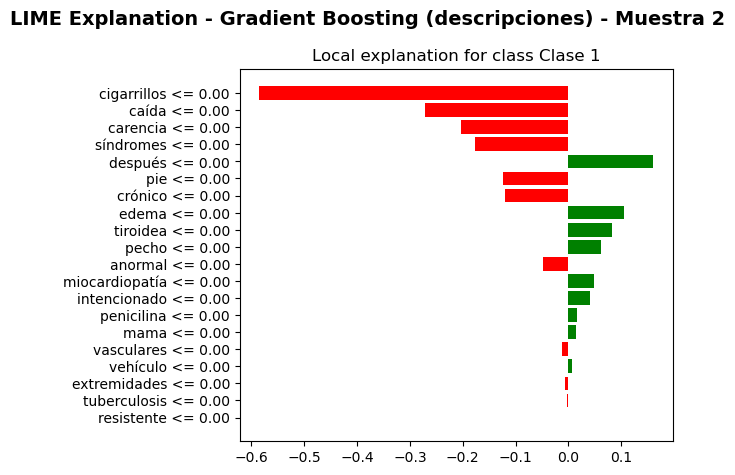

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_Gradient_Boosting/lime_plot_sample_2.png
   Procesando muestra 3/5...
Intercept 2.8129681301110097
Prediction_local [0.28050759]
Right: 0.02404049255052666
💾 Explicación HTML guardada: lime_plots_trees/descripciones_Gradient_Boosting/lime_explanation_sample_3.html


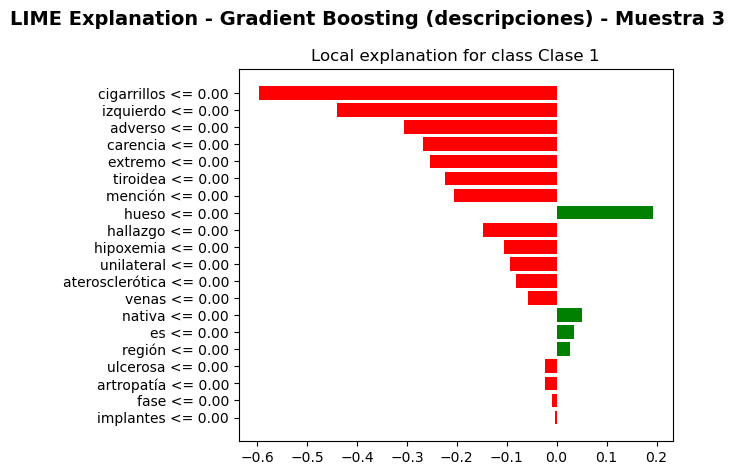

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_Gradient_Boosting/lime_plot_sample_3.png
   Procesando muestra 4/5...
Intercept 1.6030814754431206
Prediction_local [0.29862354]
Right: 0.48692071315481283
💾 Explicación HTML guardada: lime_plots_trees/descripciones_Gradient_Boosting/lime_explanation_sample_4.html


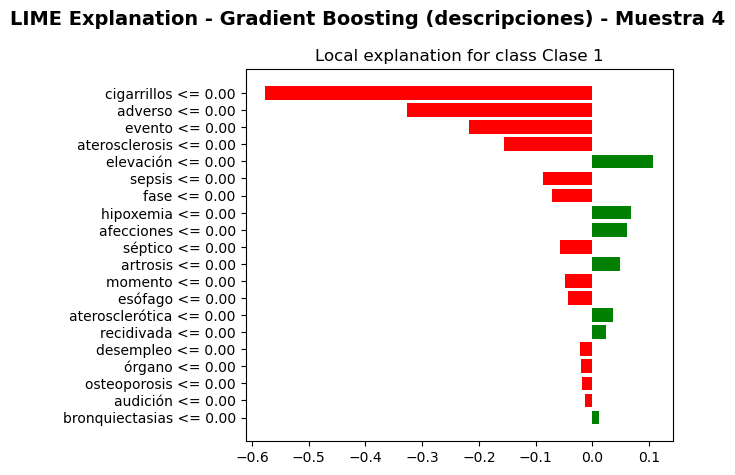

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_Gradient_Boosting/lime_plot_sample_4.png
   Procesando muestra 5/5...
Intercept 1.2959860949162796
Prediction_local [0.28701107]
Right: 0.25038910098408657
💾 Explicación HTML guardada: lime_plots_trees/descripciones_Gradient_Boosting/lime_explanation_sample_5.html


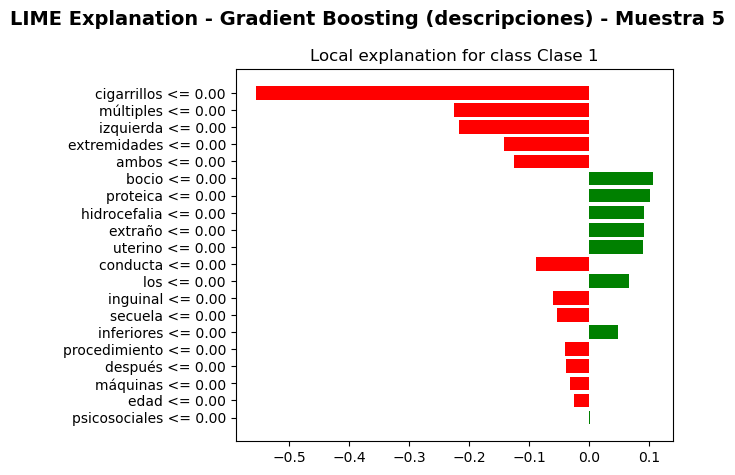

💾 Gráfico LIME guardado: lime_plots_trees/descripciones_Gradient_Boosting/lime_plot_sample_5.png
📊 Generando análisis agregado de importancia...
⚠️  Error en análisis agregado: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Traceback: Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_9524\4198431211.py", line 131, in analizar_modelo_lime
    feature_labels = [feature_names[idx] for idx in feature_indices]
                      ~~~~~~~~~~~~~^^^^^
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


🎯 PROCESANDO DATASET CON LIME: COMBINADO

📌 Analizando con LIME Random Forest en dataset: combinado
🔧 Parámetros utilizados: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'class_weight': 'balanced', 'n_estimators': 200, 'max_depth': 30, 'r

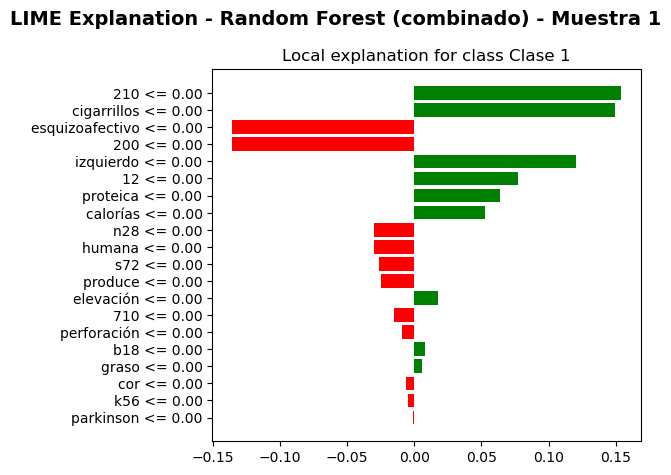

💾 Gráfico LIME guardado: lime_plots_trees/combinado_Random_Forest/lime_plot_sample_1.png
   Procesando muestra 2/5...
Intercept 0.36949975303616533
Prediction_local [0.59013141]
Right: 0.8592301896119166
💾 Explicación HTML guardada: lime_plots_trees/combinado_Random_Forest/lime_explanation_sample_2.html


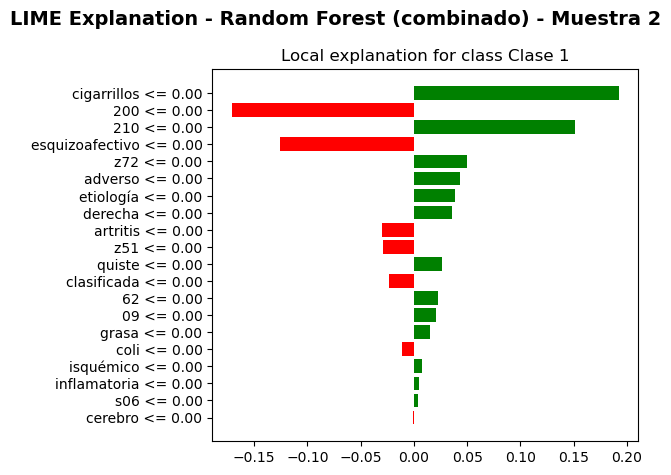

💾 Gráfico LIME guardado: lime_plots_trees/combinado_Random_Forest/lime_plot_sample_2.png
   Procesando muestra 3/5...
Intercept 0.9087237547378826
Prediction_local [0.30596801]
Right: 0.105
💾 Explicación HTML guardada: lime_plots_trees/combinado_Random_Forest/lime_explanation_sample_3.html


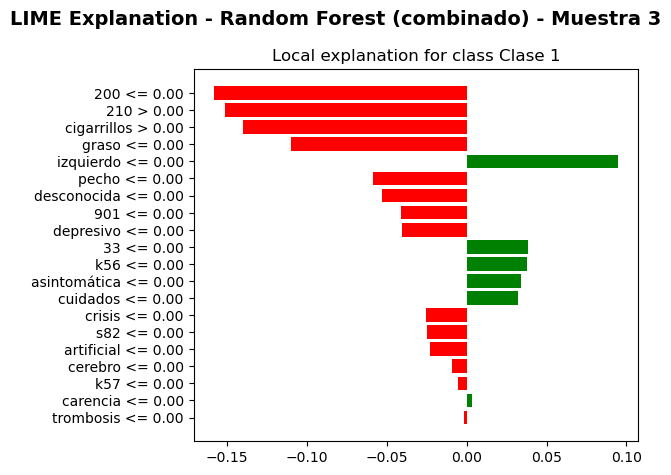

💾 Gráfico LIME guardado: lime_plots_trees/combinado_Random_Forest/lime_plot_sample_3.png
   Procesando muestra 4/5...
Intercept 0.8818233657327758
Prediction_local [0.57709484]
Right: 0.6012178519617464
💾 Explicación HTML guardada: lime_plots_trees/combinado_Random_Forest/lime_explanation_sample_4.html


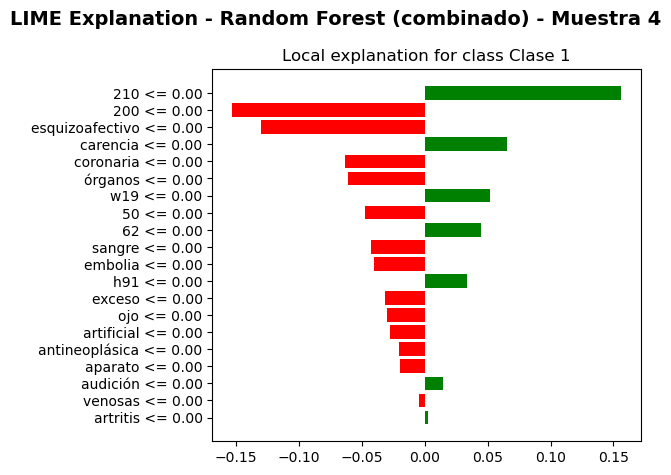

💾 Gráfico LIME guardado: lime_plots_trees/combinado_Random_Forest/lime_plot_sample_4.png
   Procesando muestra 5/5...
Intercept 0.28428745345629436
Prediction_local [0.58555439]
Right: 0.6663555799271266
💾 Explicación HTML guardada: lime_plots_trees/combinado_Random_Forest/lime_explanation_sample_5.html


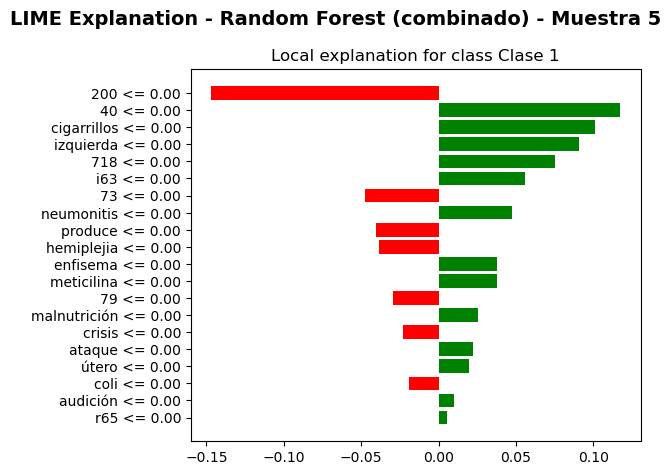

💾 Gráfico LIME guardado: lime_plots_trees/combinado_Random_Forest/lime_plot_sample_5.png
📊 Generando análisis agregado de importancia...
⚠️  Error en análisis agregado: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Traceback: Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_9524\4198431211.py", line 131, in analizar_modelo_lime
    feature_labels = [feature_names[idx] for idx in feature_indices]
                      ~~~~~~~~~~~~~^^^^^
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


📌 Analizando con LIME XGBoost en dataset: combinado
🔧 Parámetros utilizados: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 1, 'min_child_weight': 1, 'gamma': 0.1, 'scale_pos_weight': 2, 'colsample_bytree': 0.8, 'random_state': 42}
📈 Distribución de clases: {1: 1385, 0: 612}
🚀 Entrenando 

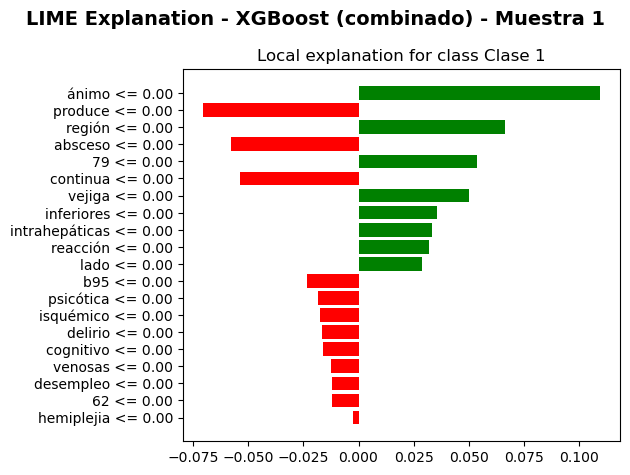

💾 Gráfico LIME guardado: lime_plots_trees/combinado_XGBoost/lime_plot_sample_1.png
   Procesando muestra 2/5...
Intercept 0.5299381080952063
Prediction_local [0.49221518]
Right: 0.51138216
💾 Explicación HTML guardada: lime_plots_trees/combinado_XGBoost/lime_explanation_sample_2.html


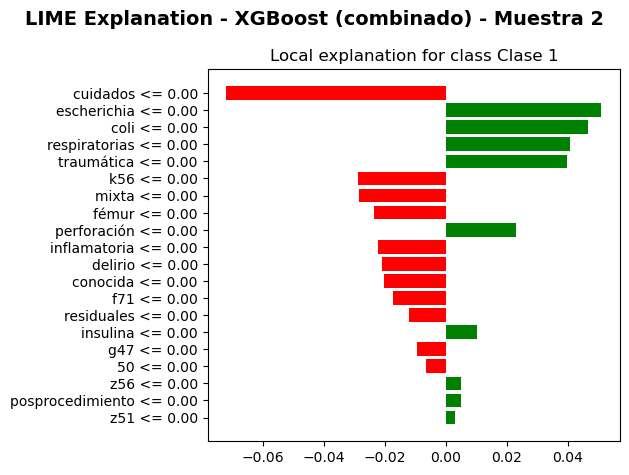

💾 Gráfico LIME guardado: lime_plots_trees/combinado_XGBoost/lime_plot_sample_2.png
   Procesando muestra 3/5...
Intercept 0.5384121928387406
Prediction_local [0.49668566]
Right: 0.47885922
💾 Explicación HTML guardada: lime_plots_trees/combinado_XGBoost/lime_explanation_sample_3.html


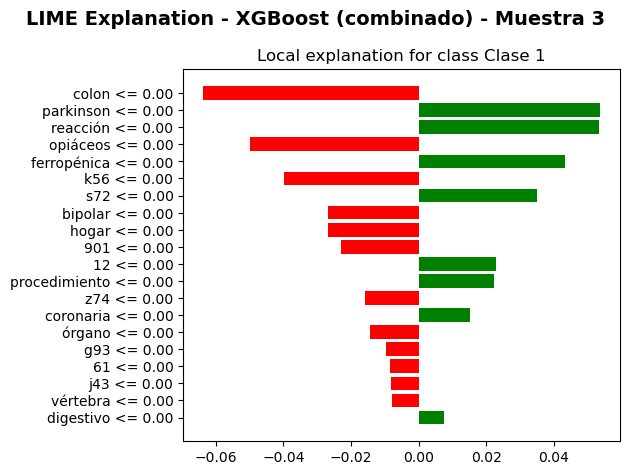

💾 Gráfico LIME guardado: lime_plots_trees/combinado_XGBoost/lime_plot_sample_3.png
   Procesando muestra 4/5...
Intercept 0.4714683395634371
Prediction_local [0.50221909]
Right: 0.4908164
💾 Explicación HTML guardada: lime_plots_trees/combinado_XGBoost/lime_explanation_sample_4.html


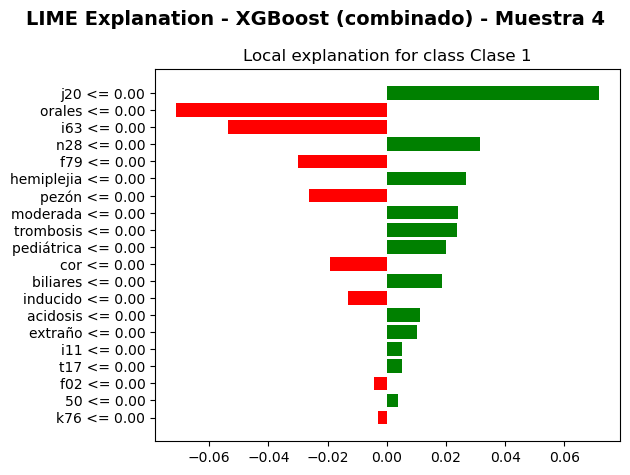

💾 Gráfico LIME guardado: lime_plots_trees/combinado_XGBoost/lime_plot_sample_4.png
   Procesando muestra 5/5...
Intercept 0.1687096428809165
Prediction_local [0.50134739]
Right: 0.63125867
💾 Explicación HTML guardada: lime_plots_trees/combinado_XGBoost/lime_explanation_sample_5.html


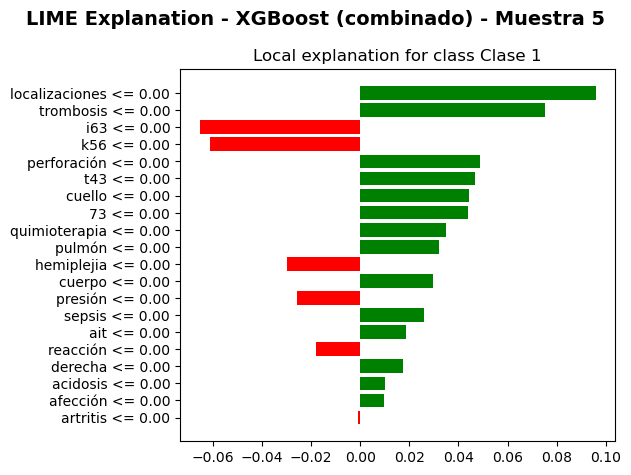

💾 Gráfico LIME guardado: lime_plots_trees/combinado_XGBoost/lime_plot_sample_5.png
📊 Generando análisis agregado de importancia...
⚠️  Error en análisis agregado: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Traceback: Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_9524\4198431211.py", line 131, in analizar_modelo_lime
    feature_labels = [feature_names[idx] for idx in feature_indices]
                      ~~~~~~~~~~~~~^^^^^
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


📌 Analizando con LIME Gradient Boosting en dataset: combinado
🔧 Parámetros utilizados: {'n_estimators': 200, 'learning_rate': 0.1, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'subsample': 1, 'max_features': None, 'random_state': 42}
📈 Distribución de clases: {1: 1385, 0: 612}
🚀 Entrenando modelo...
✅ 

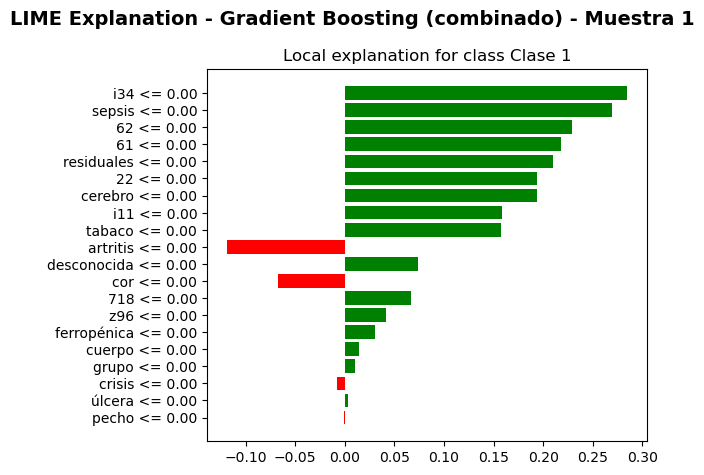

💾 Gráfico LIME guardado: lime_plots_trees/combinado_Gradient_Boosting/lime_plot_sample_1.png
   Procesando muestra 2/5...
Intercept 0.3387856523132912
Prediction_local [0.68067257]
Right: 0.9191008523452974
💾 Explicación HTML guardada: lime_plots_trees/combinado_Gradient_Boosting/lime_explanation_sample_2.html


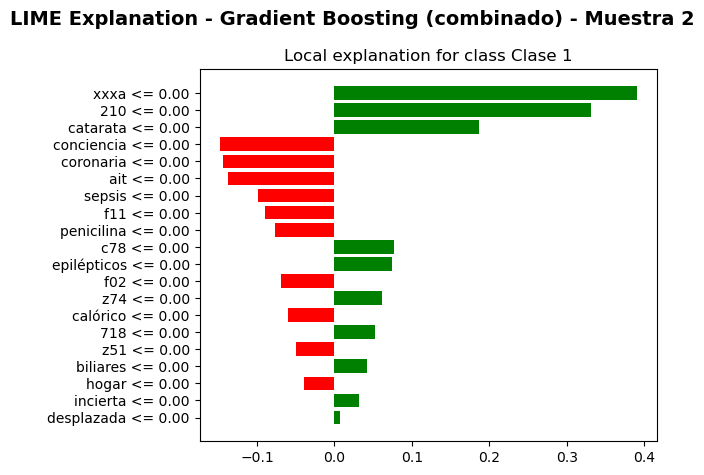

💾 Gráfico LIME guardado: lime_plots_trees/combinado_Gradient_Boosting/lime_plot_sample_2.png
   Procesando muestra 3/5...
Intercept 0.05526895899529727
Prediction_local [0.24043628]
Right: 0.03513560289382297
💾 Explicación HTML guardada: lime_plots_trees/combinado_Gradient_Boosting/lime_explanation_sample_3.html


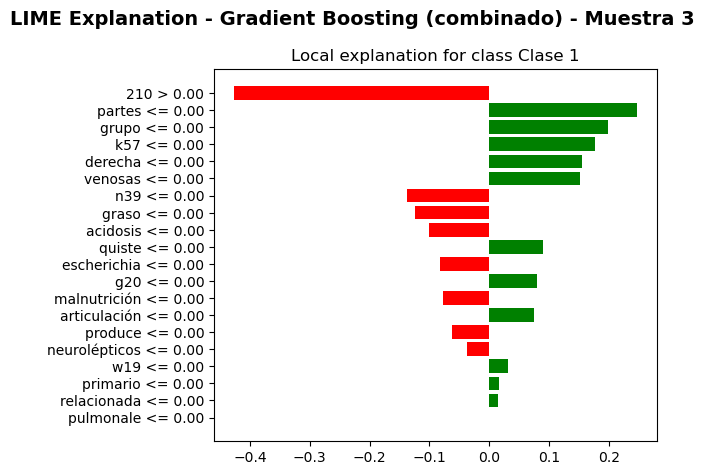

💾 Gráfico LIME guardado: lime_plots_trees/combinado_Gradient_Boosting/lime_plot_sample_3.png
   Procesando muestra 4/5...
Intercept -0.23518112056950302
Prediction_local [0.65663887]
Right: 0.5406832041613893
💾 Explicación HTML guardada: lime_plots_trees/combinado_Gradient_Boosting/lime_explanation_sample_4.html


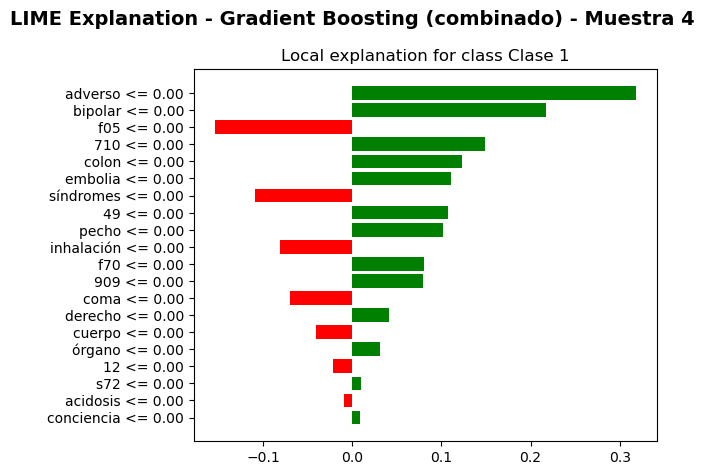

💾 Gráfico LIME guardado: lime_plots_trees/combinado_Gradient_Boosting/lime_plot_sample_4.png
   Procesando muestra 5/5...
Intercept -0.06999069757880161
Prediction_local [0.67492743]
Right: 0.8441030782578871
💾 Explicación HTML guardada: lime_plots_trees/combinado_Gradient_Boosting/lime_explanation_sample_5.html


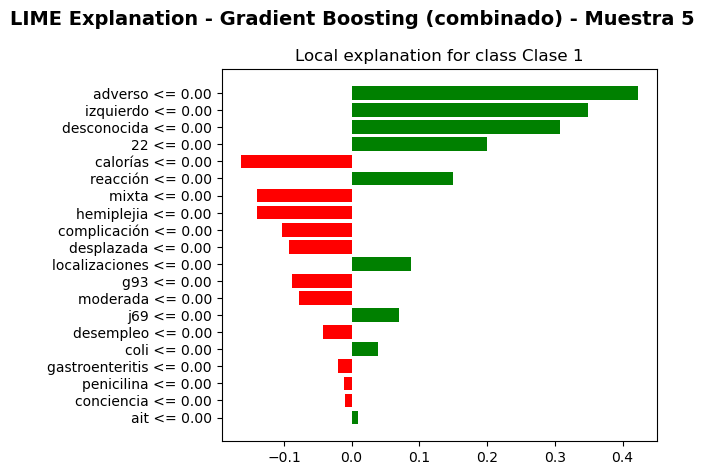

💾 Gráfico LIME guardado: lime_plots_trees/combinado_Gradient_Boosting/lime_plot_sample_5.png
📊 Generando análisis agregado de importancia...
⚠️  Error en análisis agregado: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Traceback: Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_9524\4198431211.py", line 131, in analizar_modelo_lime
    feature_labels = [feature_names[idx] for idx in feature_indices]
                      ~~~~~~~~~~~~~^^^^^
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


🎉 Análisis LIME completado!


In [5]:
# Celda 5: Análisis LIME para todos los modelos de árboles
results = {}

# Iterar sobre datasets
for dataset_name, df in datasets.items():
    print(f"\n{'='*60}")
    print(f"🎯 PROCESANDO DATASET CON LIME: {dataset_name.upper()}")
    print(f"{'='*60}")
    
    results[dataset_name] = {}
    
    # Iterar sobre modelos
    for model_key, model_class in model_classes.items():
        try:
            # Obtener parámetros específicos para este modelo y dataset
            params = all_params[dataset_name][model_key]
            model_name = model_names[model_key]
            
            # Analizar modelo con LIME
            model, accuracy = analizar_modelo_lime(
                df, dataset_name, model_class, model_name, params
            )
            
            # Guardar resultados
            results[dataset_name][model_name] = {
                "model": model,
                "accuracy": accuracy,
                "params": params
            }
            
        except KeyError as e:
            print(f"❌ No se encontraron parámetros para {model_key} en dataset {dataset_name}: {e}")
        except Exception as e:
            print(f"❌ Error procesando {model_key} en {dataset_name}: {e}")

print(f"\n🎉 Análisis LIME completado!")

In [6]:
# Celda 6: Resumen de resultados
print("\n📊 RESUMEN DE RESULTADOS CON LIME")
print("=" * 80)

for dataset_name, dataset_results in results.items():
    print(f"\n🎯 Dataset: {dataset_name.upper()}")
    print("-" * 40)
    
    if dataset_results:
        for model_name, result in dataset_results.items():
            print(f"✅ {model_name}: Accuracy = {result['accuracy']:.4f}")
    else:
        print("❌ No hay resultados disponibles")

# Encontrar el mejor modelo por dataset
print(f"\n🏆 MEJORES MODELOS POR DATASET:")
print("-" * 50)

for dataset_name, dataset_results in results.items():
    if dataset_results:
        best_model = max(dataset_results.items(), key=lambda x: x[1]['accuracy'])
        print(f"🥇 {dataset_name}: {best_model[0]} (Accuracy: {best_model[1]['accuracy']:.4f})")
    else:
        print(f"❌ {dataset_name}: No hay resultados")


📊 RESUMEN DE RESULTADOS CON LIME

🎯 Dataset: CODIGOS
----------------------------------------
✅ Random Forest: Accuracy = 0.7575
✅ XGBoost: Accuracy = 0.7525
✅ Gradient Boosting: Accuracy = 0.8050

🎯 Dataset: DESCRIPCIONES
----------------------------------------
✅ Random Forest: Accuracy = 0.8200
✅ XGBoost: Accuracy = 0.8075
✅ Gradient Boosting: Accuracy = 0.8025

🎯 Dataset: COMBINADO
----------------------------------------
✅ Random Forest: Accuracy = 0.8100
✅ XGBoost: Accuracy = 0.8075
✅ Gradient Boosting: Accuracy = 0.8025

🏆 MEJORES MODELOS POR DATASET:
--------------------------------------------------
🥇 codigos: Gradient Boosting (Accuracy: 0.8050)
🥇 descripciones: Random Forest (Accuracy: 0.8200)
🥇 combinado: Random Forest (Accuracy: 0.8100)


In [7]:
# Celda 7: Resumen de archivos LIME guardados
import glob

print("\n📁 ARCHIVOS LIME-TREES GUARDADOS")
print("=" * 80)

# Buscar todos los archivos guardados
lime_dirs = glob.glob("lime_plots_trees/*")
if lime_dirs:
    for lime_dir in sorted(lime_dirs):
        print(f"\n📂 {os.path.basename(lime_dir)}")
        print("-" * 60)
        
        # Listar archivos PNG
        png_files = glob.glob(f"{lime_dir}/*.png")
        if png_files:
            print("   🖼️  Archivos PNG:")
            for file in sorted(png_files):
                filename = os.path.basename(file)
                file_size = os.path.getsize(file) / 1024  # KB
                print(f"      📊 {filename} ({file_size:.1f} KB)")
        
        # Listar archivos HTML
        html_files = glob.glob(f"{lime_dir}/*.html")
        if html_files:
            print("   🌐 Archivos HTML:")
            for file in sorted(html_files):
                filename = os.path.basename(file)
                file_size = os.path.getsize(file) / 1024  # KB
                print(f"      📄 {filename} ({file_size:.1f} KB)")
        
        if not png_files and not html_files:
            print("   ❌ No se encontraron archivos")
    
    print(f"\n🎯 Total de directorios: {len(lime_dirs)}")
    total_png = len(glob.glob("lime_plots_trees/*/*.png"))
    total_html = len(glob.glob("lime_plots_trees/*/*.html"))
    print(f"🎯 Total de archivos PNG: {total_png}")
    print(f"🎯 Total de archivos HTML: {total_html}")
else:
    print("❌ No se encontraron directorios de gráficas LIME")

print(f"\n💡 Las gráficas se guardan en la carpeta 'lime_plots_trees/' con la estructura:")
print("   lime_plots_trees/[dataset]_[modelo]/[tipo_grafica].[png|html]")
print("📌 Los archivos HTML se pueden abrir en cualquier navegador web para visualizaciones interactivas")


📁 ARCHIVOS LIME-TREES GUARDADOS

📂 codigos_Gradient_Boosting
------------------------------------------------------------
   🖼️  Archivos PNG:
      📊 lime_plot_sample_1.png (174.5 KB)
      📊 lime_plot_sample_2.png (172.4 KB)
      📊 lime_plot_sample_3.png (174.7 KB)
      📊 lime_plot_sample_4.png (173.8 KB)
      📊 lime_plot_sample_5.png (167.3 KB)
   🌐 Archivos HTML:
      📄 lime_explanation_sample_1.html (1240.3 KB)
      📄 lime_explanation_sample_2.html (1240.3 KB)
      📄 lime_explanation_sample_3.html (1240.3 KB)
      📄 lime_explanation_sample_4.html (1240.3 KB)
      📄 lime_explanation_sample_5.html (1240.3 KB)

📂 codigos_Random_Forest
------------------------------------------------------------
   🖼️  Archivos PNG:
      📊 lime_plot_sample_1.png (163.2 KB)
      📊 lime_plot_sample_2.png (167.3 KB)
      📊 lime_plot_sample_3.png (168.5 KB)
      📊 lime_plot_sample_4.png (169.5 KB)
      📊 lime_plot_sample_5.png (166.3 KB)
   🌐 Archivos HTML:
      📄 lime_explanation_sample_1.